In [361]:
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers

In [451]:
input_dir = "./road/training/image_2/"
target_dir = "./road/training/gt_image_2/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".png")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [452]:
num_image_files = int(len(os.listdir(input_dir)))
print(f"Number of Training Examples: {num_image_files}")

num_mask_files = int(len(os.listdir(target_dir)))
print(f"Number of Training Examples: {num_mask_files}")

Number of Training Examples: 289
Number of Training Examples: 289


In [453]:
img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size))
    img = img.astype("uint8")
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (3,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

print(input_imgs.shape)
print(targets.shape)

(289, 128, 128, 3)
(289, 128, 128, 3)


In [454]:
# 모든 픽셀을 하나의 목록으로 통합
all_pixels = targets.reshape(-1, 3)

# 각 픽셀의 고유한 RGB 값을 찾기
unique_rgb_values = np.unique(all_pixels, axis=0)

print(unique_rgb_values)

[[  0   0   0]
 [  0   0 255]
 [255   0   0]
 [255   0 255]]


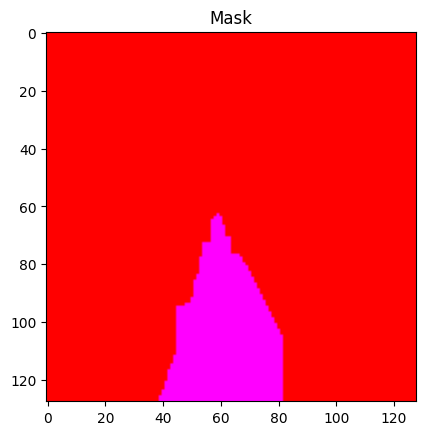

In [455]:
plt.imshow(targets[0]/255.)
plt.title(f'Mask')
plt.show()

In [456]:
# [255, 0, 255]에 해당하는 픽셀을 찾습니다.
road_mask = np.all(targets == [255, 0, 255], axis=-1)

# 데이터 타입을 int로 변환하여 0과 1의 값을 갖는 이진 마스크를 생성합니다.
binary_road_mask = road_mask.astype("uint8")
binary_road_mask = binary_road_mask[..., np.newaxis]

binary_road_mask.shape

(289, 128, 128, 1)

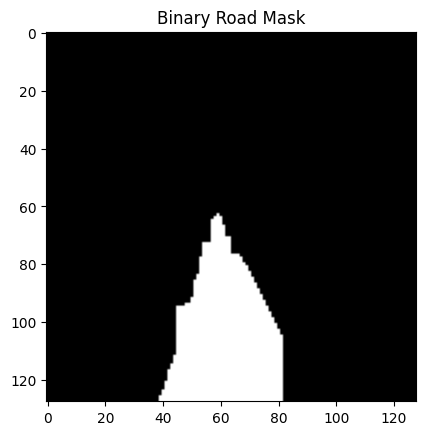

In [457]:
plt.imshow(binary_road_mask[0]/255., cmap='gray')
plt.title('Binary Road Mask')
plt.show()

In [458]:
num_val_samples = 70
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = binary_road_mask[:-num_val_samples]
test_input_imgs = input_imgs[-num_val_samples:]
test_targets = binary_road_mask[-num_val_samples:]

In [459]:
print(train_input_imgs.shape)
print(train_targets.shape)

(219, 128, 128, 3)
(219, 128, 128, 1)


In [460]:
import albumentations as A
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [461]:
train_input_imgs = train_input_imgs / 255.0
train_targets = train_targets / 255.0
train_input_imgs = train_input_imgs.astype(np.float32)
train_targets = train_targets.astype(np.float32)

In [462]:
aug_test=augmentation_pipeline(image=train_input_imgs[0], mask=train_targets[0])
aug_image_example=aug_test["image"]
aug_mask_example=aug_test["mask"]
grayscale_mask = aug_mask_example.astype(np.uint8)

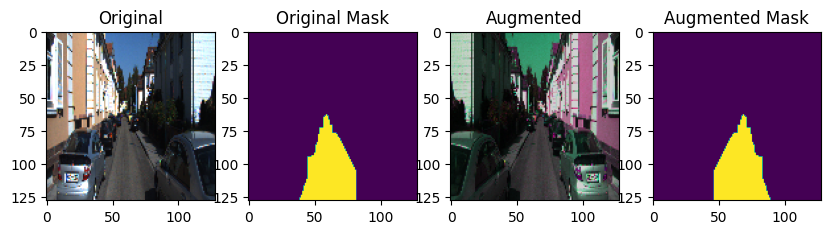

In [463]:
fig, ax = plt.subplots(1, 4, figsize=(10, 7))
ax[0].imshow(train_input_imgs[0])
ax[0].set_title("Original")

ax[1].imshow(train_targets[0])
ax[1].set_title("Original Mask")


ax[2].imshow(aug_image_example)
ax[2].set_title("Augmented")

ax[3].imshow(aug_mask_example)
ax[3].set_title("Augmented Mask")

plt.show()

In [464]:
random.seed(42)  # Fixing the random seed once
np.random.seed(42)

NewIMGS = 10  # Number of augmented images to generate per original image
augmented_images = []
augmented_masks = []

for i in range(len(train_input_imgs)):
    image = train_input_imgs[i]
    mask = train_targets[i]
    
    for j in range(NewIMGS):
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        augmented_images.append(augmented["image"])
        augmented_masks.append(augmented["mask"])

In [465]:
augmented_images = np.array(augmented_images)
np.save('./augmented_data/augmented_images.npy', augmented_images)
augmented_images.shape

(2190, 128, 128, 3)

In [466]:
augmented_masks = np.array(augmented_masks)
np.save('./augmented_data/augmented_masks.npy', augmented_masks)
augmented_masks.shape

(2190, 128, 128, 1)

In [467]:
augmented_images = np.load('./augmented_data/augmented_images.npy')
augmented_masks = np.load('./augmented_data/augmented_masks.npy')

In [469]:
def display_sample(display_list):
    plt.figure(figsize = (10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()
    
#display_sample([augmented_images[2], augmented_masks[2]])

In [470]:
# Shuffle the indices
shuffled_indices = np.random.permutation(len(augmented_images))

# Use the shuffled indices to shuffle both arrays
shuffled_data = augmented_images[shuffled_indices]
shuffled_masks = augmented_masks[shuffled_indices]

In [471]:
#train_validation split
train_set_size = int(len(shuffled_data)*0.8)

X_train=shuffled_data[:train_set_size]
y_train=shuffled_masks[:train_set_size]
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:]
y_val=shuffled_masks[train_set_size:]
print(f'validation set size {X_val.shape}')

training set size (1752, 128, 128, 3)
validation set size (438, 128, 128, 3)


In [472]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    #x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=(128, 128), num_classes=3)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 256)       5900

### Train Base Segmentation Model

In [473]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/road_segmentation_base.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(X_train, y_train,
                    epochs=5,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5


KeyboardInterrupt: 

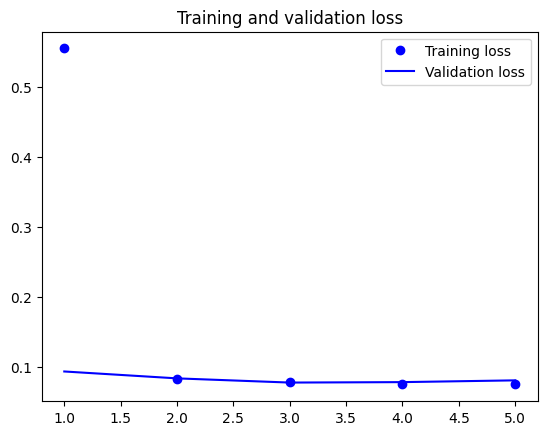

In [288]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [290]:
model = keras.models.load_model("./models/road_segmentation_base.keras")

In [291]:
# choosing a random test image
i = 1
test_image = test_input_imgs[i]
ground_truth_mask = (test_targets[i])

In [292]:
mask = model.predict(np.expand_dims(test_image, 0))[0] 

1/1 [==============================] - 0s 154ms/step


In [293]:
print(ground_truth_mask.shape)
print(mask.shape)

(128, 128, 1)
(128, 128, 3)


In [294]:
# convert mask to 2d array by taking the argmax of the predictions
mask_reshaped = np.argmax(mask, axis=-1)
print(mask_reshaped.shape)
# extend the dimensions of the mask to be 3d - 
# this is actually not needed for visualization
# and done here just so that the shape is the same as the target, for esthetics only
mask_reshaped = np.expand_dims(mask_reshaped, -1)
print(mask_reshaped.shape)

(128, 128)
(128, 128, 1)


In [295]:
# print the predicted and ground truth classification label
print(np.unique(np.round(mask_reshaped)))
print(np.unique(ground_truth_mask))

[0]
[ 75 104 255]


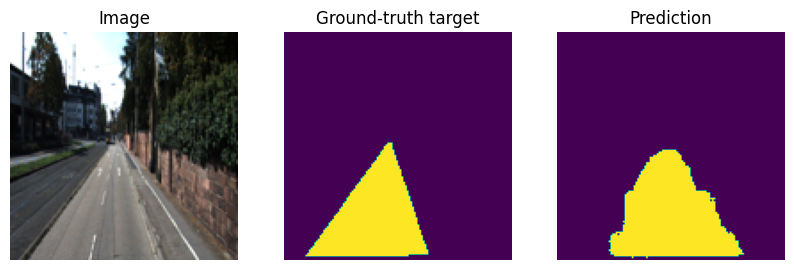

In [107]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(mask_reshaped)

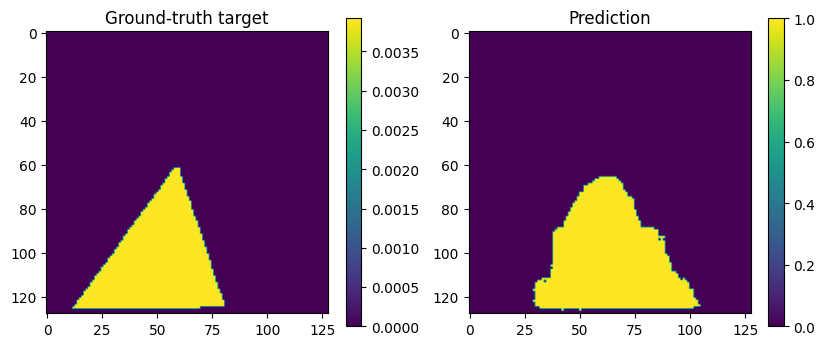

In [55]:
# show a color legend
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Ground-truth target")
plt.imshow(ground_truth_mask)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(mask_reshaped)
plt.colorbar()

In [108]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(ground_truth_mask, mask_reshaped)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.41555786


Fine-tuning

In [109]:
def get_model2(img_size, num_classes):
    base = keras.applications.DenseNet121(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False  # Freeze the base model

    inputs = keras.Input(shape=img_size + (3,))
    x = base(inputs, training=False)  # Use base in inference mode

    # Start transposed convolutions
    x = layers.Conv2DTranspose(512, 3, activation="relu", padding="same", strides=2)(x)  # 8x8
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)  # 16x16
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)  # 32x32
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)   # 64x64
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same", strides=2)(x)   # 128x128

    # Output layer
    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    model2 = keras.Model(inputs, outputs)
    return model2

img_size = (128, 128)  # Adjust as necessary for your application
num_classes = 3
model2 = get_model2(img_size=img_size, num_classes=3)
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 512)        4719104   
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 16, 16, 256)      1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 32, 32, 128)      295040    
 Transpose)                                                      
                                                           

In [48]:
model2.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks2 = [
    keras.callbacks.ModelCheckpoint("./models/finetuningmodel.keras",
                                    save_best_only=True)
]

history2 = model2.fit(X_train, y_train,
                    epochs=50,
                    callbacks=callbacks2,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/50
40/40 [==============================] - 217s 5s/step - loss: 0.4643 - val_loss: 0.2749
Epoch 2/50
40/40 [==============================] - 213s 5s/step - loss: 0.2639 - val_loss: 0.2171
Epoch 3/50
40/40 [==============================] - 207s 5s/step - loss: 0.2374 - val_loss: 0.1934
Epoch 4/50
40/40 [==============================] - 212s 5s/step - loss: 0.2013 - val_loss: 0.1871
Epoch 5/50
40/40 [==============================] - 217s 5s/step - loss: 0.1793 - val_loss: 0.1518
Epoch 6/50
40/40 [==============================] - 196s 5s/step - loss: 0.1647 - val_loss: 0.1469
Epoch 7/50
40/40 [==============================] - 193s 5s/step - loss: 0.1567 - val_loss: 0.1700
Epoch 8/50
40/40 [==============================] - 187s 5s/step - loss: 0.1460 - val_loss: 0.1515
Epoch 9/50
40/40 [==============================] - 191s 5s/step - loss: 0.1397 - val_loss: 0.1756
Epoch 10/50
40/40 [==============================] - 196s 5s/step - loss: 0.1313 - val_loss: 0.1465
Epoch 11/

KeyboardInterrupt: 

In [110]:
model_fine_tune = keras.models.load_model("./models/finetuningmodel.keras")

In [121]:
i = 1
test_image = X_test[i]
ground_truth_mask = (y_test[i])

In [117]:
mask2 = model_fine_tune.predict(np.expand_dims(test_image, 0))[0] 

1/1 [==============================] - 0s 71ms/step


In [118]:
# convert mask to 2d array by taking the argmax of the predictions
mask_reshaped = np.argmax(mask2, axis=-1)
print(mask_reshaped.shape)
# extend the dimensions of the mask to be 3d - 
# this is actually not needed for visualization
# and done here just so that the shape is the same as the target, for esthetics only
mask_reshaped = np.expand_dims(mask_reshaped, -1)
print(mask_reshaped.shape)

(128, 128)
(128, 128, 1)


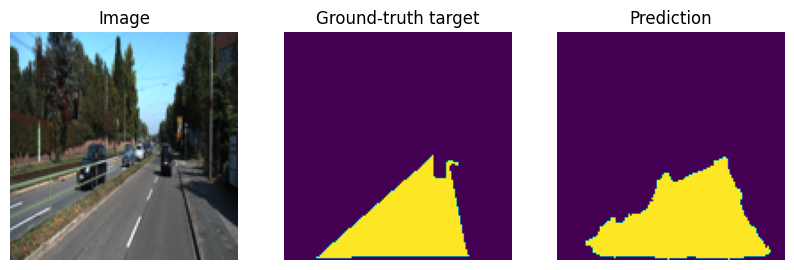

In [119]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(mask_reshaped)

In [120]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(ground_truth_mask, mask_reshaped)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.3987732
